In [1]:
import pandas as pd
import polars as pl
import numpy as np
import lightgbm as lgb

import os
import matplotlib.pyplot as plt

In [2]:
# base_path = '/content/drive/MyDrive/DMEyF/2024/'
base_path = 'C:/Eugenio/Maestria/DMEyF/'
# base_path = '/home/eanegrin/buckets/b1/'

dataset_path = base_path + 'datasets/'
modelos_path = base_path + 'modelos/'
db_path = base_path + 'db/'
dataset_file = 'competencia_03_fe_v02.parquet' # CAMBIAR EN LA VM

ganancia_acierto = 273000
costo_estimulo = 7000

# agregue sus semillas
semillas = [122219, 109279, 400391, 401537, 999961]

In [3]:
data = pl.scan_parquet(dataset_path + dataset_file).filter(pl.col("foto_mes") == 202107).collect()

In [4]:
# convierto a pandas dataframe
data = data.to_pandas()

In [5]:
# Asignamos pesos a las clases

data['clase_peso'] = 1.0

data.loc[data['clase_ternaria'] == 'BAJA+2', 'clase_peso'] = 1.00002
data.loc[data['clase_ternaria'] == 'BAJA+1', 'clase_peso'] = 1.00001

In [6]:
data['clase_binaria'] = 0
data['clase_binaria'] = np.where(data['clase_ternaria'] == 'BAJA+2', 1, 0)

In [7]:
X_test = data.drop(['clase_ternaria', 'clase_peso', 'clase_binaria'], axis=1)
y_test = data['clase_binaria']
w_test = data['clase_peso']

Cargo los modelos pre-entrenados (mismo modelo - 5 semillas distintas)

In [19]:
version = 'v002'

modelos_folder = modelos_path + version

modelos = [f'{modelos_folder}/{modelo}' for modelo in os.listdir(modelos_folder) if not modelo.endswith('final.txt')]

In [20]:
modelos

['C:/Eugenio/Maestria/DMEyF/modelos/v002/lgb_competencia3_v002_s109279.txt',
 'C:/Eugenio/Maestria/DMEyF/modelos/v002/lgb_competencia3_v002_s122219.txt',
 'C:/Eugenio/Maestria/DMEyF/modelos/v002/lgb_competencia3_v002_s400391.txt',
 'C:/Eugenio/Maestria/DMEyF/modelos/v002/lgb_competencia3_v002_s401537.txt',
 'C:/Eugenio/Maestria/DMEyF/modelos/v002/lgb_competencia3_v002_s999961.txt']

In [21]:
ganancia_acumulada = []
ganancia_maxima = []
numero_envios = []

# Iterate over each model
for modelo in modelos:
    # Load the pre-trained model
    model = lgb.Booster(model_file=modelo)

    # Predict with the model
    y_pred_lgm = model.predict(X_test)

    # Calculate the profit
    ganancia = np.where(w_test == 1.00002, ganancia_acierto, 0) - np.where(w_test != 1.00002, costo_estimulo, 0)
    
    # Sort the profits based on the predictions
    idx = np.argsort(y_pred_lgm)[::-1]
    ganancia = ganancia[idx]
    
    # Ganancia acumulada
    ganancia_cum = np.cumsum(ganancia)
    ganancia_acumulada.append(ganancia_cum)
    
    # Ganancia maxima
    ganancia_max = ganancia_cum.max()
    ganancia_maxima.append(ganancia_max)
    
    # numero optimo de envios
    gan_max_idx = np.where(ganancia_cum == ganancia_max)[0][0]
    numero_envios.append(gan_max_idx)


# Promedio de todas las semillas:
ganancia_acumulada_promedio = np.mean(ganancia_acumulada, axis=0)
ganancia_maxima_promedio = ganancia_acumulada_promedio.max()
numero_envios_promedio = np.where(ganancia_acumulada_promedio == ganancia_maxima_promedio)[0][0]

print(f'En promedio la ganancia obtenida es {ganancia_maxima_promedio/1000000} millones y se alcanza con {numero_envios_promedio} envios')
print(f'El desvio estandar de la ganancia maxima es de {np.std(ganancia_maxima)/1000000} millones y de {np.std(numero_envios)} envios')

En promedio la ganancia obtenida es 173.663 millones y se alcanza con 13526 envios
El desvio estandar de la ganancia maxima es de 1.0086375761392197 millones y de 370.33260726001436 envios


In [22]:
# resultados individuales
pd.DataFrame({
    'Ganancia Maxima': ganancia_maxima,
    'Numero de Envios': numero_envios,
    'Semilla': semillas
})

,Ganancia Maxima,Numero de Envios,Semilla
0,174461000,14276,122219
1,172711000,13526,109279
2,174657000,13168,400391
3,172956000,13491,401537
4,175301000,13436,999961


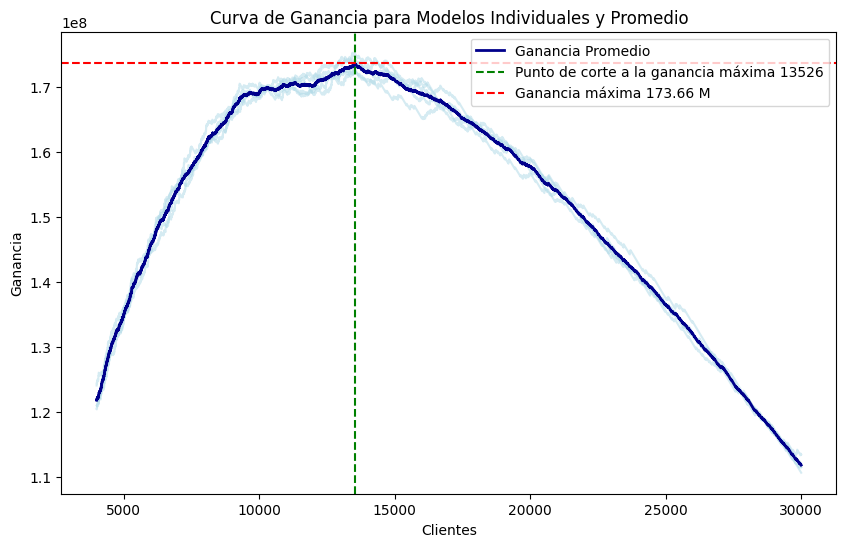

In [23]:
piso_envios = 4000
techo_envios = 30000

plt.figure(figsize=(10, 6))
for ganancia_cum in ganancia_acumulada:
    plt.plot(
        range(piso_envios, len(ganancia_cum[piso_envios:techo_envios]) + piso_envios),
        ganancia_cum[piso_envios:techo_envios],
        color='lightblue',
        alpha=0.5
    )

plt.plot(
    range(piso_envios, len(ganancia_acumulada_promedio[piso_envios:techo_envios]) + piso_envios),
    ganancia_acumulada_promedio[piso_envios:techo_envios],
    color='darkblue',
    linewidth=2,
    label='Ganancia Promedio'
)

plt.axvline(
    x=numero_envios_promedio,
    color='g',
    linestyle='--',
    label=f'Punto de corte a la ganancia máxima {numero_envios_promedio}'
)

plt.axhline(
    y=ganancia_maxima_promedio,
    color='r',
    linestyle='--',
    label=f'Ganancia máxima {ganancia_maxima_promedio/1000000:.2f} M'
)

plt.title('Curva de Ganancia para Modelos Individuales y Promedio')
plt.xlabel('Clientes')
plt.ylabel('Ganancia')
plt.legend()
plt.show()

In [30]:
from sklearn.model_selection import train_test_split

private_idx, public_idx = train_test_split(X_test.index, test_size=0.1, random_state=1123425556, stratify=y_test)

In [34]:
model = lgb.Booster(model_file=modelos[0])

y_pred_lgm = model.predict(X_test)
ganancia = np.where(w_test == 1.00002, ganancia_acierto, 0) - np.where(w_test != 1.00002, costo_estimulo, 0)

idx = np.argsort(y_pred_lgm)[::-1]
y_pred_lgm = y_pred_lgm[idx]
ganancia = ganancia[idx]

df_cut_point = pd.DataFrame({'ganancia': ganancia, 'y_pred_lgm': y_pred_lgm})

In [35]:
df_cut_point['public'] = 0.0
df_cut_point['private'] = 0.0
df_cut_point.loc[private_idx, 'private'] = ganancia[private_idx] / 0.9
df_cut_point.loc[public_idx, 'public'] = ganancia[public_idx] / 0.1

df_cut_point['nro_envios'] = df_cut_point.reset_index().index

df_cut_point['public_cum'] = df_cut_point['public'].cumsum()
df_cut_point['private_cum'] = df_cut_point['private'].cumsum()

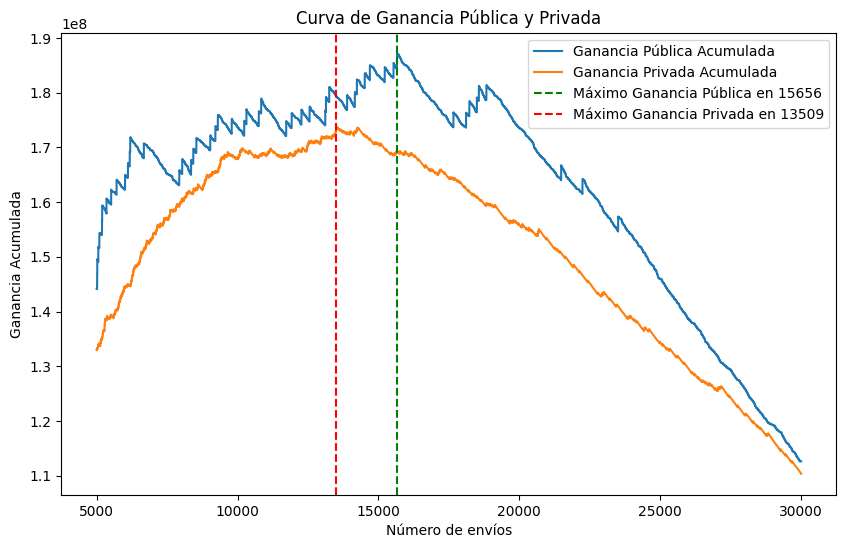

In [37]:
plt.figure(figsize=(10, 6))
plt.plot(df_cut_point['nro_envios'][5000:30000], df_cut_point['public_cum'][5000:30000], label='Ganancia Pública Acumulada')
plt.plot(df_cut_point['nro_envios'][5000:30000], df_cut_point['private_cum'][5000:30000], label='Ganancia Privada Acumulada')

max_public_cum = df_cut_point['public_cum'][5000:30000].max()
max_public_idx = df_cut_point['public_cum'][5000:30000].idxmax()
plt.axvline(x=max_public_idx, color='g', linestyle='--', label=f'Máximo Ganancia Pública en {max_public_idx}')

max_private_cum = df_cut_point['private_cum'][5000:30000].max()
max_private_idx = df_cut_point['private_cum'][5000:30000].idxmax()
plt.axvline(x=max_private_idx, color='r', linestyle='--', label=f'Máximo Ganancia Privada en {max_private_idx}')

plt.title('Curva de Ganancia Pública y Privada')
plt.xlabel('Número de envíos')
plt.ylabel('Ganancia Acumulada')
plt.legend()
plt.show()